<a href="https://colab.research.google.com/github/villoll/clothing_recommendation/blob/main/clothing_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Немного теории

**Правила:**
* добавление в корзину => высшая оценка; Например, 100
* добавление в избранное => хорошая оценка; Например, 50
* просмотров страницы товара целиком => хорошо; Например, 15

Нормировать между 1 - 10

# Импортирование необходимых библиотек

In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from PIL import Image
import matplotlib.pyplot as plt


# Создание датасетов

**Журнал действий пользователя**

In [2]:
user_log = {'user_id' : [1, 1, 1, 2, 2, 2, 3, 3, 3, 1], 'item_id': [1, 2, 3, 1, 2, 3, 1, 2, 3, 4], 'add_cart' : [1, 0, 1, 0, 1, 0, 1, 0, 0, 1], 'add_fav' : [0, 0, 1, 0, 0, 1, 0, 1, 1, 0], 'page_view' : [1, 2, 3, 2, 3, 1, 4, 2, 6, 1]}
user_log

{'user_id': [1, 1, 1, 2, 2, 2, 3, 3, 3, 1],
 'item_id': [1, 2, 3, 1, 2, 3, 1, 2, 3, 4],
 'add_cart': [1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
 'add_fav': [0, 0, 1, 0, 0, 1, 0, 1, 1, 0],
 'page_view': [1, 2, 3, 2, 3, 1, 4, 2, 6, 1]}

In [3]:
user_log_df = pd.DataFrame.from_dict(user_log)
user_log_df        

,user_id,item_id,add_cart,add_fav,page_view
0,1,1,1,0,1
1,1,2,0,0,2
2,1,3,1,1,3
3,2,1,0,0,2
4,2,2,1,0,3
5,2,3,0,1,1
6,3,1,1,0,4
7,3,2,0,1,2
8,3,3,0,1,6
9,1,4,1,0,1


**Данные о товарах**

In [4]:
item_data = {'item_id': [1, 2, 3, 4], 'article': ['1', '2', '3', '4'], 'category':['dresses and sundresses', 'outwears', 't-shirts and polo', ''], 'subcategory': ['evening dresses','coats', 't-shirts', ''], 'brand' : ['lichi', 'zarina', 'befree', 'zarina'], 'color': ['blue', 'black', 'yellow', 'blue'], 'material' : ['polyester','polyester','cotton', ''], 'season' : ['multi','demi','multi', ''], 'price' : ['3500', '8000', '1500', ''], 'image' : ['/content/items_photo/1.webp', '/content/items_photo/2.webp', '/content/items_photo/3.webp', '/content/items_photo/4.webp']}
item_data

{'item_id': [1, 2, 3, 4],
 'article': ['1', '2', '3', '4'],
 'category': ['dresses and sundresses', 'outwears', 't-shirts and polo', ''],
 'subcategory': ['evening dresses', 'coats', 't-shirts', ''],
 'brand': ['lichi', 'zarina', 'befree', 'zarina'],
 'color': ['blue', 'black', 'yellow', 'blue'],
 'material': ['polyester', 'polyester', 'cotton', ''],
 'season': ['multi', 'demi', 'multi', ''],
 'price': ['3500', '8000', '1500', ''],
 'image': ['/content/items_photo/1.webp',
  '/content/items_photo/2.webp',
  '/content/items_photo/3.webp',
  '/content/items_photo/4.webp']}

In [5]:
item_df = pd.DataFrame.from_dict(item_data)
item_df = item_df.replace('', np.nan)
item_df

,item_id,article,category,subcategory,brand,color,material,season,price,image
0,1,1,dresses and sundresses,evening dresses,lichi,blue,polyester,multi,3500,/content/items_photo/1.webp
1,2,2,outwears,coats,zarina,black,polyester,demi,8000,/content/items_photo/2.webp
2,3,3,t-shirts and polo,t-shirts,befree,yellow,cotton,multi,1500,/content/items_photo/3.webp
3,4,4,NaN,NaN,zarina,blue,NaN,NaN,NaN,/content/items_photo/4.webp


# Подсчет рейтинга для коллаборативной системы

In [6]:
#Веса событий
w1 = 100
w2 = 50
w3 = 15

#Расчет неявных оценок
def calculate_rating_for_user(userid):
    data = userid
    
    ratings = dict()
    maxrating = 0
   
    for i, v in data.iterrows():
    
        rating = w1 * v['add_cart'] + w2 * v['add_fav'] + w3 * v['page_view']
        maxrating = max(maxrating, rating)
        ratings[v['item_id']] = rating
        
    for item in ratings.keys():
        ratings[item] = (10 * ratings[item] / maxrating).round(2)
        
    #return dict(sorted(ratings.items(), key=lambda item: -item[1]))
    return ratings

def save_ratings(ratings, userid, temp):
    
    for item_id, rating in ratings.items():
        temp['user_id'].append(userid)
        temp['item_id'].append(item_id)
        temp['rating'].append(rating)
        
    return temp
        
    
def calculate_ratings():
    temp = {'user_id': [], 'item_id' : [], 'rating': []}
    for user in user_log_df['user_id'].unique():
        ratings = (calculate_rating_for_user(user_log_df[user_log_df['user_id'] == user]))
        temp = save_ratings(ratings, user, temp)
    
    return temp

ratings = calculate_ratings()
ratings

{'user_id': [1, 1, 1, 1, 2, 2, 2, 3, 3, 3],
 'item_id': [1, 2, 3, 4, 1, 2, 3, 1, 2, 3],
 'rating': [5.9, 1.54, 10.0, 5.9, 2.07, 10.0, 4.48, 10.0, 5.0, 8.75]}

**Матрица предпочтений**

In [7]:
ratings_df = pd.DataFrame.from_dict(ratings)
user_item_matrix = ratings_df.pivot(index = 'item_id', columns = 'user_id', values= 'rating')
user_item_matrix.head()

user_id,1,2,3
item_id,,,
1,5.90,2.07,10.00
2,1.54,10.00,5.00
3,10.00,4.48,8.75
4,5.90,NaN,NaN


In [8]:
user_item_matrix.fillna(0, inplace = True)
user_item_matrix.head()

user_id,1,2,3
item_id,,,
1,5.90,2.07,10.00
2,1.54,10.00,5.00
3,10.00,4.48,8.75
4,5.90,0.00,0.00


**Обучение модели**

In [9]:
csr_data = csr_matrix(user_item_matrix.values)
csr_data

<4x3 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [10]:
knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute', n_neighbors = 2, n_jobs = -1)

knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=2)

In [11]:
user_item_matrix = user_item_matrix.rename_axis(None, axis = 1).reset_index()
user_item_matrix.head()

,item_id,1,2,3
0,1,5.90,2.07,10.00
1,2,1.54,10.00,5.00
2,3,10.00,4.48,8.75
3,4,5.90,0.00,0.00


**Составление рекомендаций**

In [12]:
recommendations = 3 #Количество рекомендаций

item_id = 2
index_id = user_item_matrix[user_item_matrix['item_id'] == item_id].index[0]

distances, indices = knn.kneighbors(csr_data[index_id], n_neighbors = recommendations + 1)

In [13]:
indices_list = indices.squeeze().tolist()
distances_list = distances.squeeze().tolist()

indices_distances = list(zip(indices_list, distances_list))

indices_distances_sorted = sorted(indices_distances, key = lambda x: x[1], reverse = False)

indices_distances_sorted = indices_distances_sorted[1:]
indices_distances_sorted

[(2, 0.34315923333610554), (0, 0.40057508937803865), (3, 0.8635465820104888)]

In [14]:
recom_list = []

for ind_dist in indices_distances_sorted:

    matrix_item_id = user_item_matrix.iloc[ind_dist[0]]['item_id']

    id = item_df[item_df['item_id'] == matrix_item_id].index

    article = item_df.iloc[id]['article'].values[0]
    dist = ind_dist[1]

    recom_list.append({'Article' : article, 'Distance' : dist})
    
    
recom_df = pd.DataFrame(recom_list, index = range(1, recommendations + 1))
recom_df

,Article,Distance
1,3,0.343159
2,1,0.400575
3,4,0.863547


In [15]:
recom_df.reset_index().drop('index', axis = 1)

,Article,Distance
0,3,0.343159
1,1,0.400575
2,4,0.863547


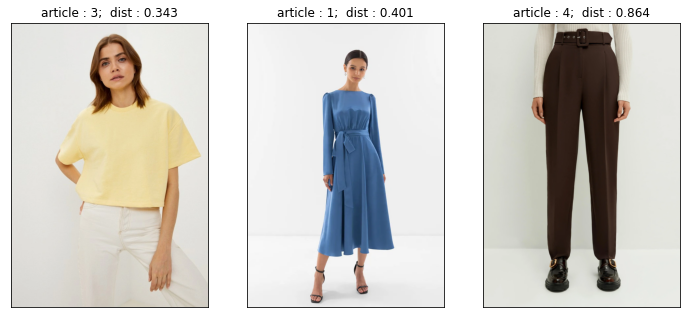

In [16]:
fig, axes = plt.subplots(1, len(recom_df))

for i, row in recom_df.iterrows():
    article = row[0]
    path = item_df[item_df['article'] == article]['image'].item()
    img = Image.open(path).convert('RGB')
    axes[i-1].imshow(img)
    axes[i-1].set_title('article : {article}; '.format(article = article) + ' dist : {dist}'.format(dist = round(row[1], 3)))

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

fig.set_figwidth(12)
fig.set_figheight(6)

plt.show()
    

# Подсчет рейтинга для item-based системы

In [17]:
#расчета косинусного сходства
def similar(x, y):
    
    xLen = np.linalg.norm(x)
    yLen = np.linalg.norm(y)

    result = np.dot(x, y)/(xLen * yLen)
    
    return result

Мы можем векторизовать определенное событие. Пользователь, который в рамках текущей сессии просматривал некоторое множество товаров с заданным распределением цветов, готовится посмотреть какой-то новый товар, например красный. Используя исторические данные о показах и кликах, можно построить модель, которая бы предсказывала вероятность клика по красному товару при условии наличия у него существующего распределения цветов у просмотренных ранее товаров.


In [18]:
user_1 = user_log_df[user_log_df['user_id'] == 1]
user_1


,user_id,item_id,add_cart,add_fav,page_view
0,1,1,1,0,1
1,1,2,0,0,2
2,1,3,1,1,3
9,1,4,1,0,1


In [19]:
item_df

,item_id,article,category,subcategory,brand,color,material,season,price,image
0,1,1,dresses and sundresses,evening dresses,lichi,blue,polyester,multi,3500,/content/items_photo/1.webp
1,2,2,outwears,coats,zarina,black,polyester,demi,8000,/content/items_photo/2.webp
2,3,3,t-shirts and polo,t-shirts,befree,yellow,cotton,multi,1500,/content/items_photo/3.webp
3,4,4,NaN,NaN,zarina,blue,NaN,NaN,NaN,/content/items_photo/4.webp


In [20]:
brand_cart_add = {'lichi' : [], 'zarina' : [], 'befree': []}
color_cart_add = {'blue' : [], 'black' : [], 'yellow' : []}
brand_page_view = {'lichi' : [], 'zarina' : [], 'befree': []}
color_page_view = {'blue' : [], 'black' : [], 'yellow' : []}

for i, row in user_1.iterrows():
    id = row[1]
    brand = item_df[item_df['item_id'] == id]['brand'].item()
    color = item_df[item_df['item_id'] == id]['color'].item()
   
    brand_cart_add[brand].append(row[2])
    color_cart_add[color].append(row[2])
    brand_page_view[brand].append(row[4])
    color_page_view[color].append(row[4])
    
print(brand_cart_add, color_cart_add, brand_page_view, color_page_view)

{'lichi': [1], 'zarina': [0, 1], 'befree': [1]} {'blue': [1, 1], 'black': [0], 'yellow': [1]} {'lichi': [1], 'zarina': [2, 1], 'befree': [3]} {'blue': [1, 1], 'black': [2], 'yellow': [3]}


In [21]:
list_feature = [brand_cart_add, color_cart_add, brand_page_view, color_page_view]
session_list_of_user = []

for f in list_feature:
    count = 0
    for v in f.values():
        count += sum(v)
    for v in f.values():
        session_list_of_user.append( round(sum(v) / count, 2))

print(session_list_of_user)

[0.33, 0.33, 0.33, 0.67, 0.0, 0.33, 0.14, 0.43, 0.43, 0.29, 0.29, 0.43]


In [22]:
#Для сравнения товары должны иметь подобный вектор -> проблема 
#Пока что сократим session_list_of_user до признаков cart_add

cut_session_list = session_list_of_user[6:13]

In [23]:
#Представляем товары подобным вектором
temp_dict = {'lichi' : [], 'zarina' : [], 'befree': [], 'blue' : [], 'black' : [], 'yellow' : []}

for i, row in item_df.iterrows():
    brand = row['brand']
    color = row['color']
    
    for key in temp_dict:
        if key == brand:
            temp_dict[key].append(1)
        elif key == color:
            temp_dict[key].append(1)
        else:
            temp_dict[key].append(0)

temp_list = []
for i in range(len(temp_dict['lichi'])):
    temp_list.append([])

for value in temp_dict.values():
    for i in range(len(value)):
        temp_list[i].append(value[i])
temp_list

items_array = np.array(temp_list)
items_array

array([[1, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 1],
       [0, 1, 0, 1, 0, 0]])

In [24]:
user_sess_array = np.array(cut_session_list)
user_sess_array

array([0.14, 0.43, 0.43, 0.29, 0.29, 0.43])

# Расчет косинусного сходства

In [25]:
for i, item in enumerate(items_array, 1):
  print(f'Товар {i} с оценками {item} имеет сходство с вектором пользователя {np.round(similar(item, user_sess_array), 3)}')

Товар 1 с оценками [1 0 0 1 0 0] имеет сходство с вектором пользователя 0.353
Товар 2 с оценками [0 1 0 0 1 0] имеет сходство с вектором пользователя 0.591
Товар 3 с оценками [0 0 1 0 0 1] имеет сходство с вектором пользователя 0.706
Товар 4 с оценками [0 1 0 1 0 0] имеет сходство с вектором пользователя 0.591


In [26]:
indices_list = []
distances_list = []

for i, item in enumerate(items_array, 1):
    indices_list.append(i)
    distances_list.append(np.round(similar(item, user_sess_array), 3))
                          
indices_distances = list(zip(indices_list, distances_list))

indices_distances_sorted = sorted(indices_distances, key = lambda x: x[1], reverse = False)

indices_distances_sorted

[(1, 0.353), (2, 0.591), (4, 0.591), (3, 0.706)]

In [27]:
recom_list_item = []

for ind_dist in indices_distances_sorted:
    
    id = ind_dist[0]
    article = item_df.loc[item_df['item_id'] == id]['article'].values[0]
    dist = ind_dist[1]

    recom_list_item.append({'Article' : article, 'Distance' : dist})
    
    
recom_item_df = pd.DataFrame(recom_list_item, index = range(1, recommendations + 2))
recom_item_df

,Article,Distance
1,1,0.353
2,2,0.591
3,4,0.591
4,3,0.706


In [28]:
recom_item_df.reset_index().drop('index', axis = 1)

,Article,Distance
0,1,0.353
1,2,0.591
2,4,0.591
3,3,0.706


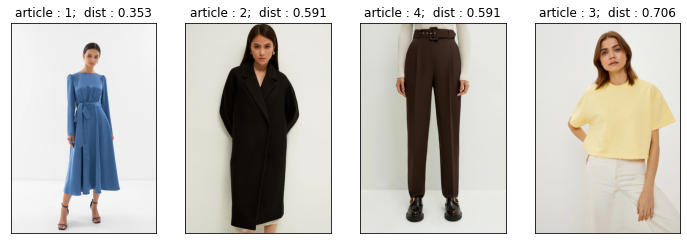

In [29]:
fig, axes = plt.subplots(1, len(recom_item_df))

for i, row in recom_item_df.iterrows():
    article = row[0]
    path = item_df[item_df['article'] == article]['image'].item()
    img = Image.open(path).convert('RGB')
    axes[i-1].imshow(img)
    axes[i-1].set_title('article : {article}; '.format(article = article) + ' dist : {dist}'.format(dist = round(row[1], 3)))

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

fig.set_figwidth(12)
fig.set_figheight(6)

plt.show()
    